In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle
plt.rcParams["figure.figsize"]= (12, 7)
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline

## Loading Datset ##

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Bank%20Marketing/termdeposit_train.csv', sep=',')
df.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


In [3]:
df.describe()

,ID,age,balance,day,duration,campaign,pdays,previous
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,22563.972162,40.957247,1363.890258,15.835466,258.113534,2.765697,39.576042,0.574272
std,13075.936990,10.625134,3028.304293,8.337097,257.118973,3.113830,99.317592,2.422529
min,2.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11218.000000,33.000000,73.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,22519.000000,39.000000,450.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,33879.500000,48.000000,1431.000000,21.000000,318.500000,3.000000,-1.000000,0.000000
max,45211.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df.shape

(31647, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          31647 non-null  int64 
 1   age         31647 non-null  int64 
 2   job         31647 non-null  object
 3   marital     31647 non-null  object
 4   education   31647 non-null  object
 5   default     31647 non-null  object
 6   balance     31647 non-null  int64 
 7   housing     31647 non-null  object
 8   loan        31647 non-null  object
 9   contact     31647 non-null  object
 10  day         31647 non-null  int64 
 11  month       31647 non-null  object
 12  duration    31647 non-null  int64 
 13  campaign    31647 non-null  int64 
 14  pdays       31647 non-null  int64 
 15  previous    31647 non-null  int64 
 16  poutcome    31647 non-null  object
 17  subscribed  31647 non-null  object
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


In [6]:
df.isnull().sum()

ID            0
age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

In [7]:
print(df.head())

      ID  age         job   marital  education default  balance housing loan  \
0  26110   56      admin.   married    unknown      no     1933      no   no   
1  40576   31     unknown   married  secondary      no        3      no   no   
2  15320   27    services   married  secondary      no      891     yes   no   
3  43962   57  management  divorced   tertiary      no     3287      no   no   
4  29842   31  technician   married  secondary      no      119     yes   no   

     contact  day month  duration  campaign  pdays  previous poutcome  \
0  telephone   19   nov        44         2     -1         0  unknown   
1   cellular   20   jul        91         2     -1         0  unknown   
2   cellular   18   jul       240         1     -1         0  unknown   
3   cellular   22   jun       867         1     84         3  success   
4   cellular    4   feb       380         1     -1         0  unknown   

  subscribed  
0         no  
1         no  
2         no  
3        yes  
4    

In [8]:
# Target variable distribution
count = df.groupby('subscribed').size()
percent = count/len(df)*100
print(percent)

subscribed
no     88.261131
yes    11.738869
dtype: float64


## From the distribution of Target variable: "response" it is found that data is imbalanced becouse there is approx 88% is 'no' and 12% is 'yes'.
I have did analysis of each individual variable and checking if there is any outlier values present.

Outliers can be defined as values out of range [(Q1-1.5IQR) , (Q3+1.5IQR)] but here I choose a range based on Maximum Minimum value for each variable selected by observing Boxplot of corresponding variable.

After identify, Outlier values will be imputed by "mean" of respective variable by implementation of following "impute_outliers" function.

In [9]:
####Impute outliers function
def impute_outliers(df, column , minimum, maximum):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<minimum, col_values>maximum), col_values.mean(), col_values)
    return df

In [10]:
                                                      ### lets see statistic of Numerical variables before Outlier treatment
df.describe()

,ID,age,balance,day,duration,campaign,pdays,previous
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,22563.972162,40.957247,1363.890258,15.835466,258.113534,2.765697,39.576042,0.574272
std,13075.936990,10.625134,3028.304293,8.337097,257.118973,3.113830,99.317592,2.422529
min,2.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11218.000000,33.000000,73.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,22519.000000,39.000000,450.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,33879.500000,48.000000,1431.000000,21.000000,318.500000,3.000000,-1.000000,0.000000
max,45211.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## From the above result one can see that some variables ('duration', 'campaign', 'pdays', 'previous') has outliers. That can also visualize through graph further.

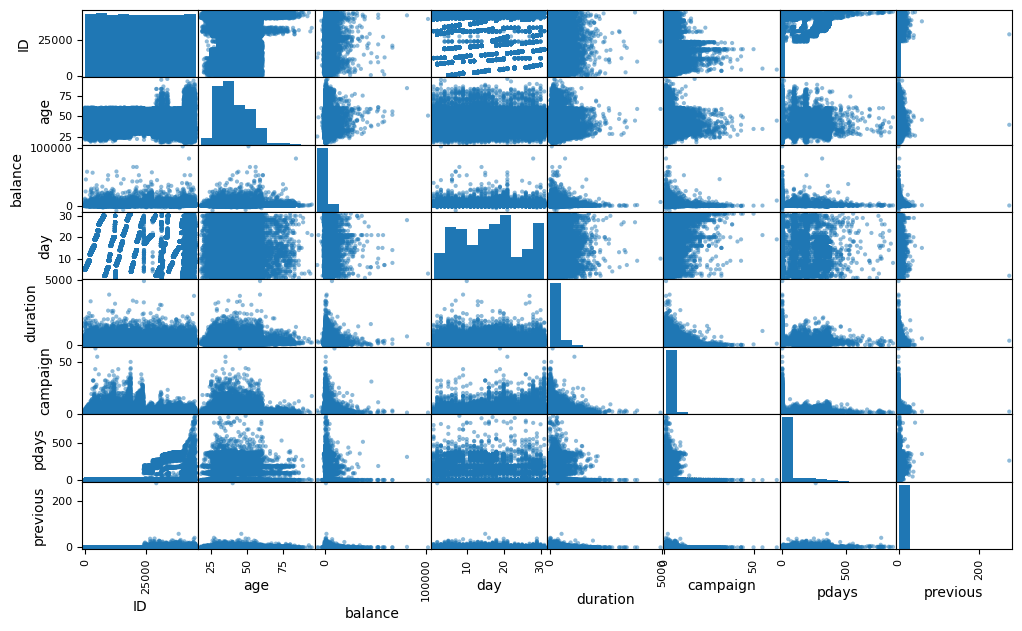

In [11]:
                                                                                                 # scatter plot matrix
scatter_matrix(df)
plt.show()

### Scatter plot matrix showing that there is no strong relationship between these indepedent variables (no multicollinearity among these).

Lets analyze all Independent Numerical variables against Target variable 'response' by plotting Boxplot. We can easily find outliers through Boxplot

<Axes: xlabel='subscribed', ylabel='age'>

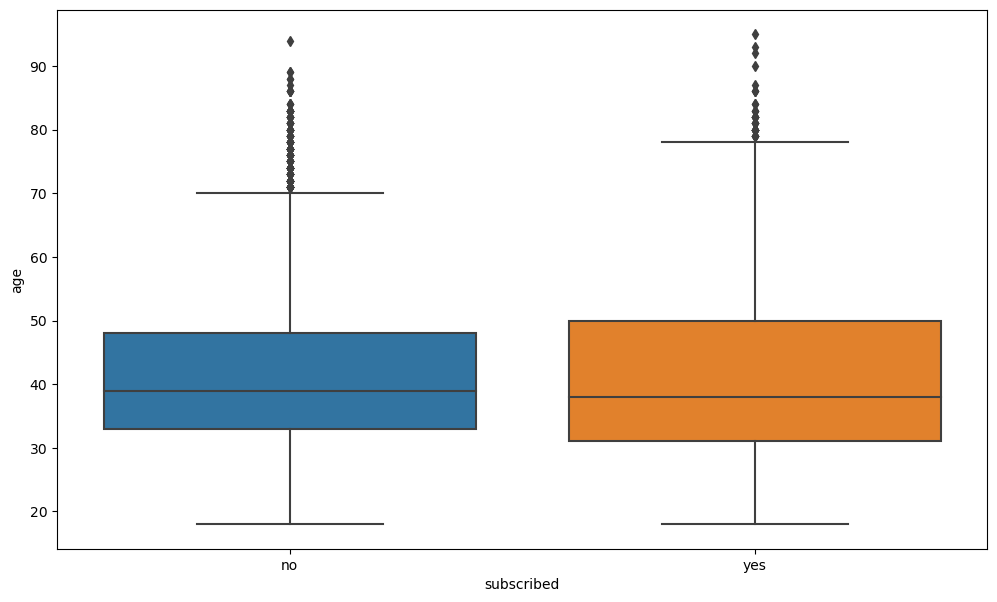

In [12]:
                                                                                                    #### age
sns.boxplot(x='subscribed', y='age', data=df)

In [13]:
                                                                                            ### Fixing balance column
dataset_new = df
min_val = dataset_new["balance"].min()
max_val = 20000
dataset_new = impute_outliers(df=dataset_new, column='balance' , minimum=min_val, maximum=max_val)

<Axes: xlabel='subscribed', ylabel='day'>

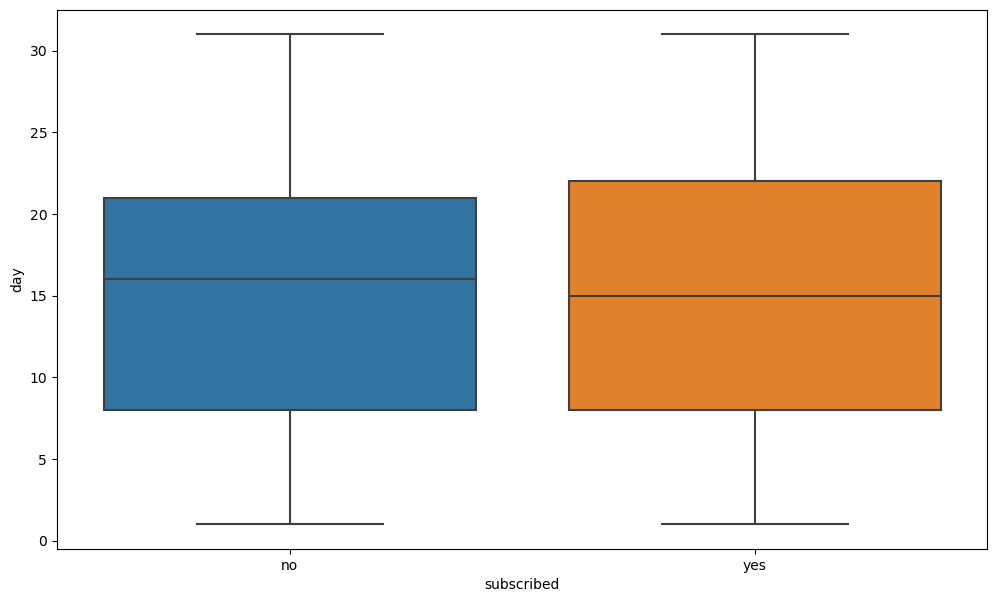

In [14]:
                                                                                                      ####day

sns.boxplot(x='subscribed', y='day', data=df)

<Axes: xlabel='subscribed', ylabel='duration'>

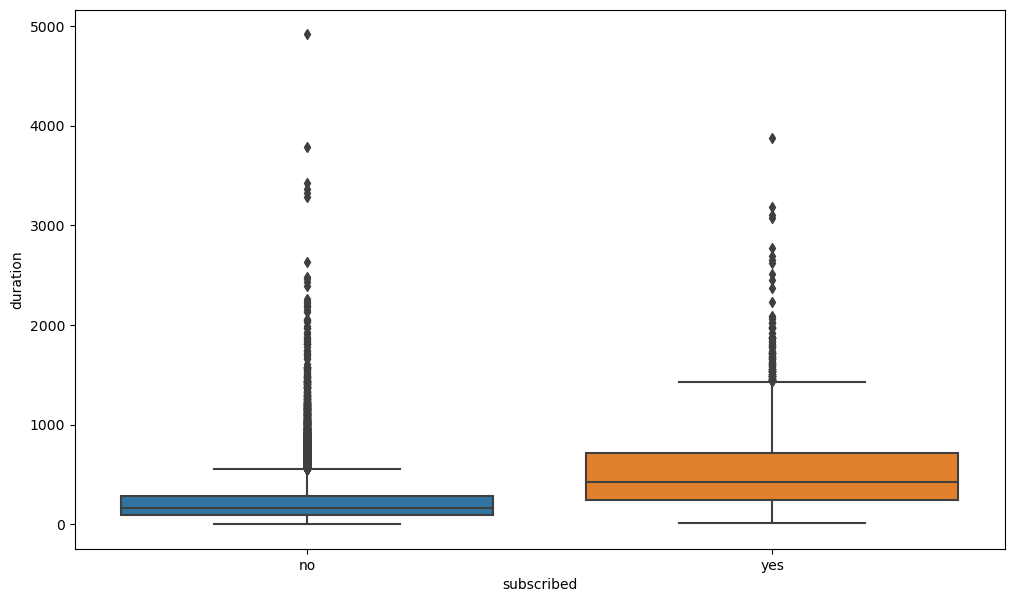

In [15]:
                                                                                                 ####duration

sns.boxplot(x='subscribed', y='duration', data=df)

In [16]:
                                                                                #### Fixing duration column
min_val = dataset_new["duration"].min()
max_val = 2000
dataset_new = impute_outliers(df=dataset_new, column='duration' , minimum=min_val, maximum=max_val)

<Axes: xlabel='subscribed', ylabel='campaign'>

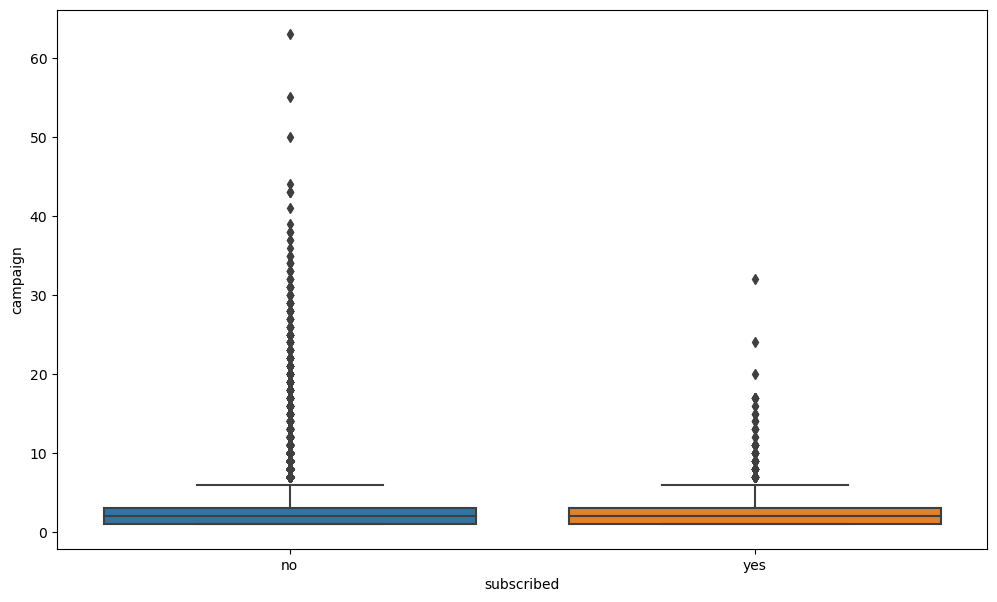

In [17]:
#campaign

sns.boxplot(x='subscribed', y='campaign', data=df)

In [18]:
# Fixing campaign column
min_val = dataset_new["campaign"].min()
max_val = 20
dataset_new = impute_outliers(df=dataset_new, column='campaign' , minimum=min_val, maximum=max_val)

<Axes: xlabel='subscribed', ylabel='pdays'>

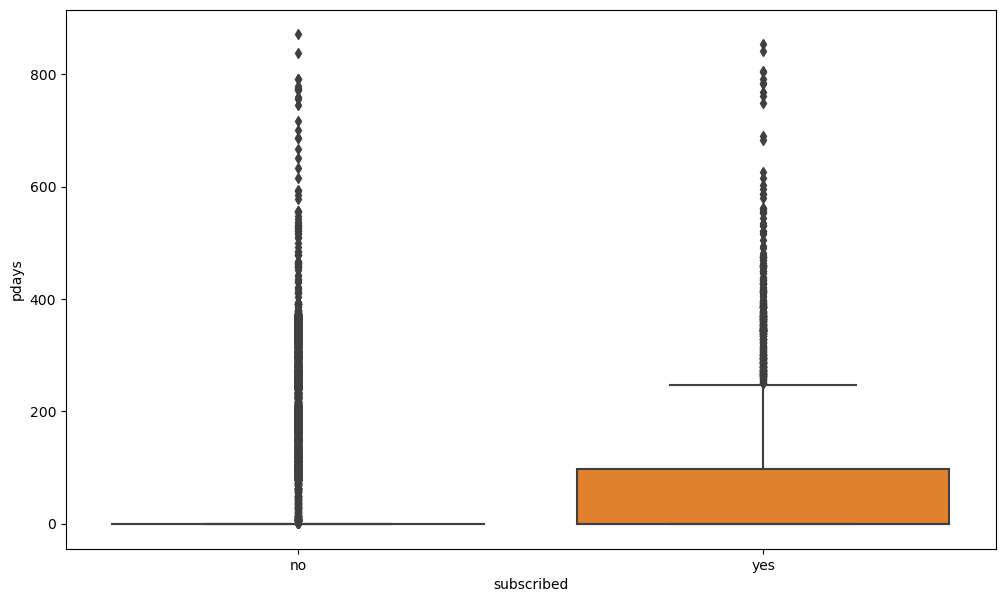

In [19]:
#pdays

sns.boxplot(x='subscribed', y='pdays', data=df)

In [20]:
# Fixing pdays column
min_val = dataset_new["pdays"].min()
max_val = 250
dataset_new = impute_outliers(df=dataset_new, column='pdays' , minimum=min_val, maximum=max_val)

<Axes: xlabel='subscribed', ylabel='previous'>

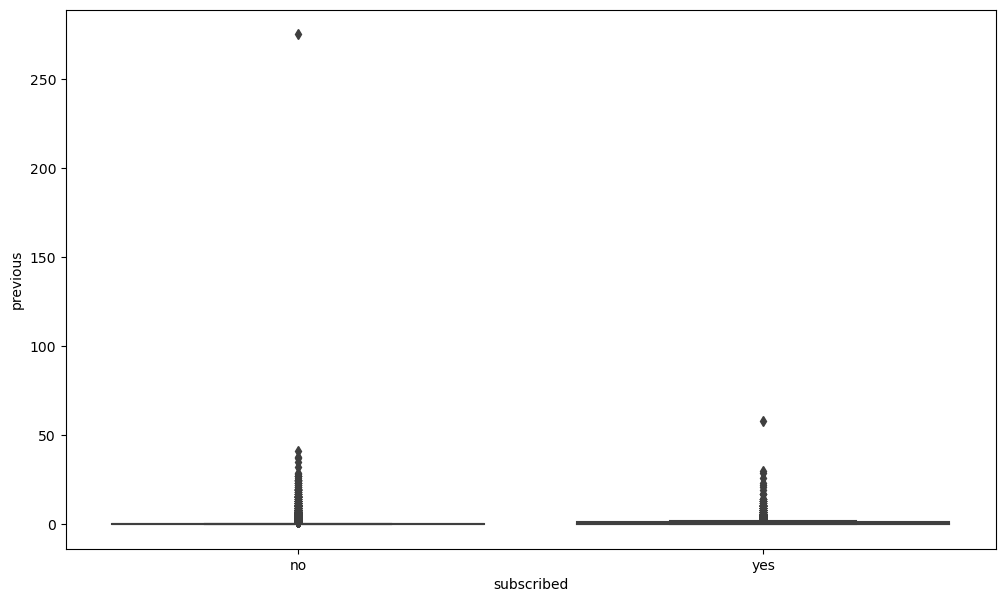

In [21]:
#previous

sns.boxplot(x='subscribed', y='previous', data=df)

In [22]:
# Fixing 'previous' column
min_val = dataset_new["previous"].min()
max_val = 15
dataset_new = impute_outliers(df=dataset_new, column='previous' , minimum=min_val, maximum=max_val)

In [23]:
#lets see statistic of Numerical variables after Outlier treatment
dataset_new.describe()

,ID,age,balance,day,duration,campaign,pdays,previous
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,22563.972162,40.957247,1242.239151,15.835466,255.095575,2.630414,17.164163,0.515357
std,13075.936990,10.625134,2219.038780,8.337097,241.987118,2.466694,47.756688,1.509918
min,2.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11218.000000,33.000000,73.000000,8.000000,104.000000,1.000000,-1.000000,0.000000
50%,22519.000000,39.000000,450.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,33879.500000,48.000000,1403.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,45211.000000,95.000000,19850.000000,31.000000,1994.000000,20.000000,250.000000,15.000000


## Analysis of Indepedent Categorical Variables
Note:

If any Categorical variable has more than 50% unknown values or seems highly unbalanced, we can drop that variable from dataset.
If unknown values are less than 50% than we can replace them by Mode of respective variable by implementing following 'impute_unknowns' function.

In [25]:
# Impute unknowns function
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', dataset[column].mode(), col_values)
    return df

job
admin.           11.473441
blue-collar      21.619743
entrepreneur      3.185136
housemaid         2.761715
management       20.978292
retired           4.973615
self-employed     3.548520
services          9.173065
student           2.006509
technician       16.769362
unemployed        2.859671
unknown           0.650931
dtype: float64


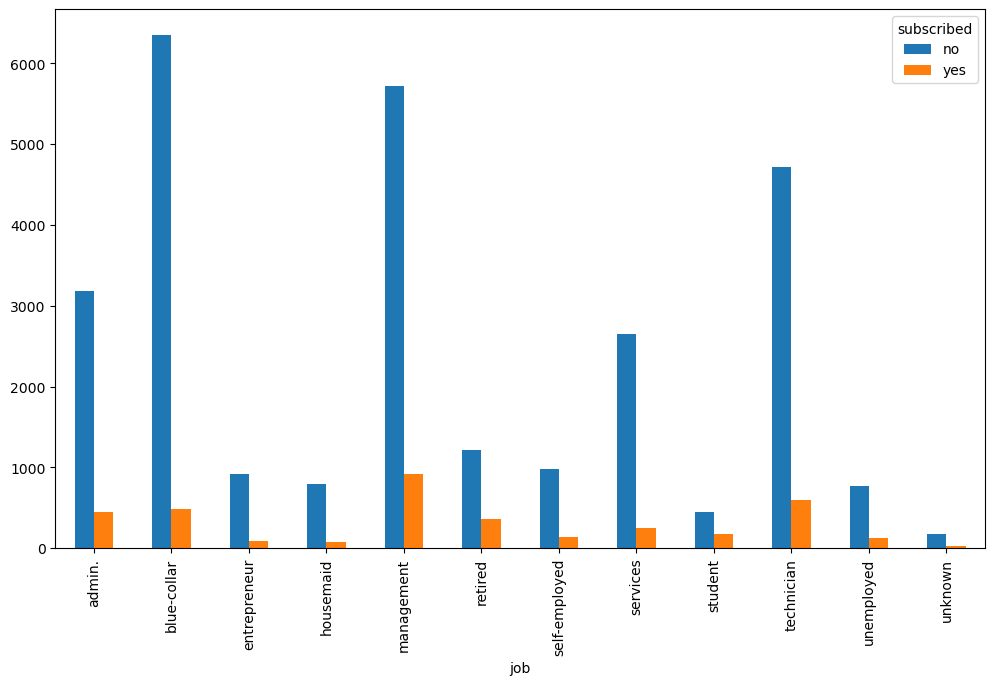

In [26]:
# job
temp1 = pd.crosstab(df['job'], df['subscribed'])
temp1.plot(kind='bar')
print(df.groupby(['job']).size()/len(df)*100)

marital
divorced    11.470282
married     60.337473
single      28.192246
dtype: float64


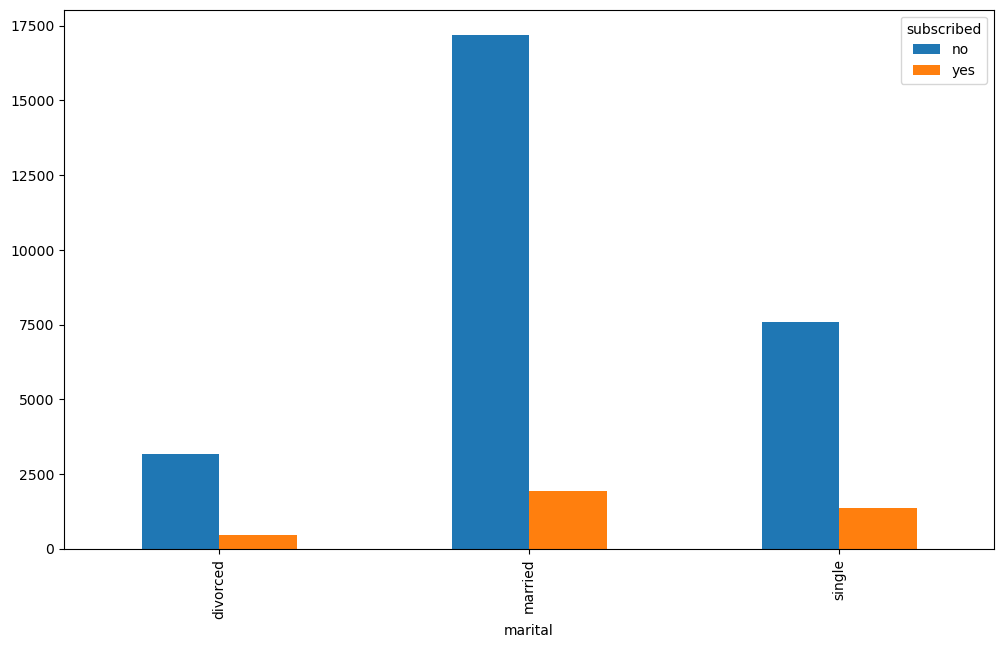

In [27]:
# marital
temp2 = pd.crosstab(df['marital'], df['subscribed'])
temp2.plot(kind='bar')
print(df.groupby(['marital']).size()/len(df)*100)

education
primary      15.192593
secondary    51.265523
tertiary     29.389832
unknown       4.152052
dtype: float64


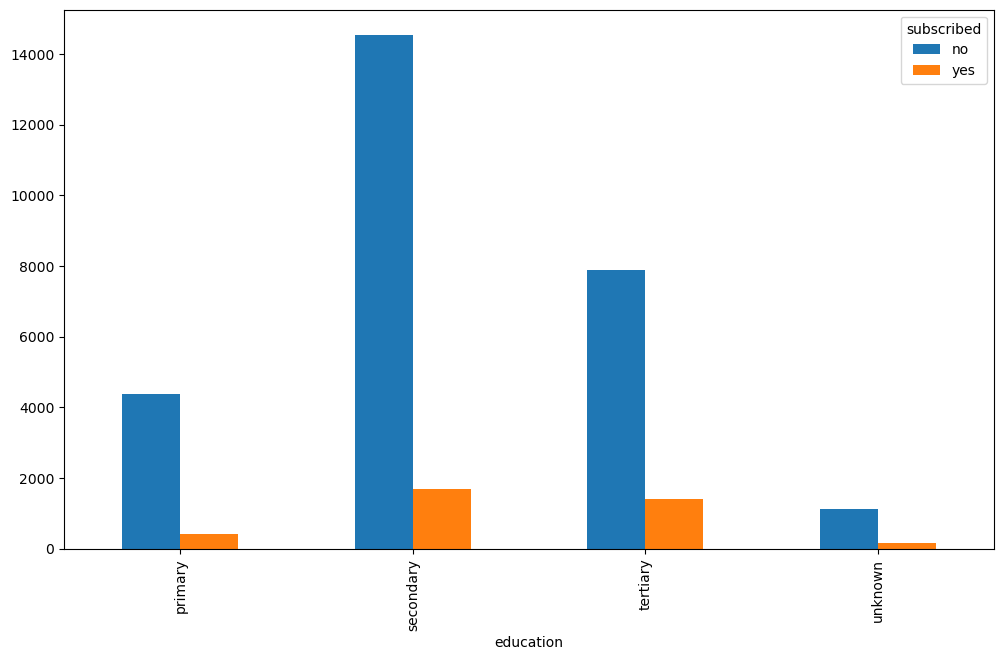

In [28]:
# education
temp3 = pd.crosstab(df['education'], df['subscribed'])
temp3.plot(kind='bar')
print(df.groupby(['education']).size()/len(df)*100)

default
no     98.151484
yes     1.848516
dtype: float64


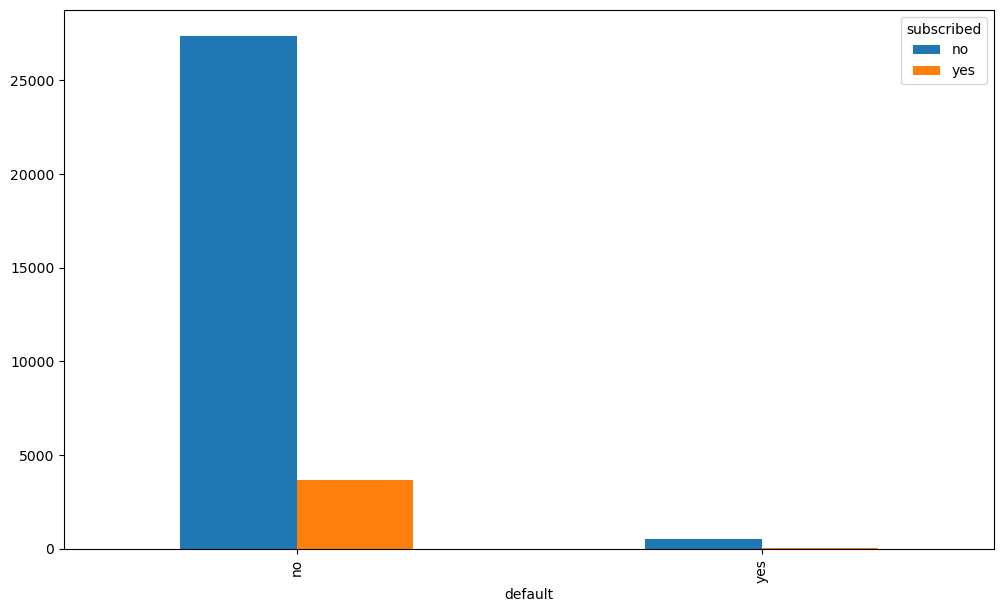

In [29]:
# default
temp4 = pd.crosstab(df['default'], df['subscribed'])
temp4.plot(kind='bar')
print(df.groupby(['default']).size()/len(df)*100)

housing
no     44.437071
yes    55.562929
dtype: float64


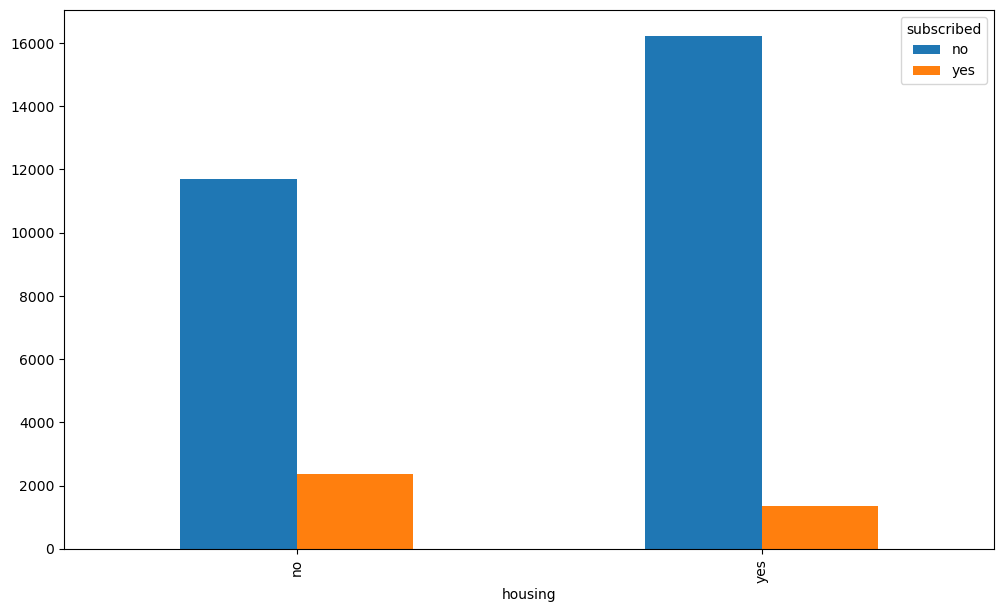

In [30]:
# housing
temp5 = pd.crosstab(df['housing'], df['subscribed'])
temp5.plot(kind='bar')
print(df.groupby(['housing']).size()/len(df)*100)

contact
cellular     64.533763
telephone     6.468228
unknown      28.998009
dtype: float64


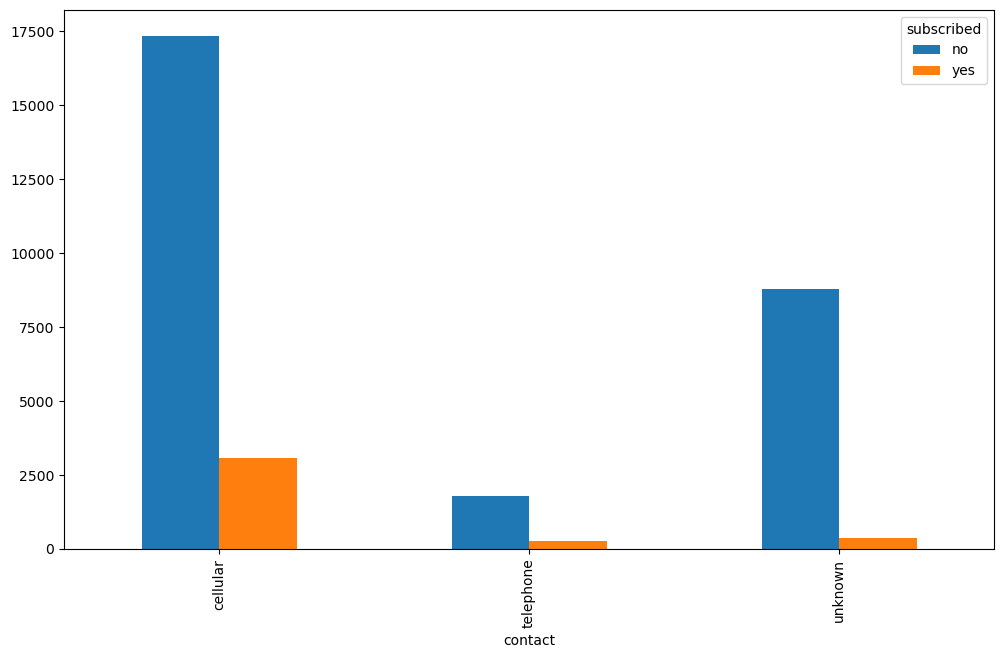

In [31]:
# "contact"
temp6 = pd.crosstab(df['contact'], df['subscribed'])
temp6.plot(kind='bar')
print(df.groupby(['contact']).size()/len(df)*100)

month
apr     6.493506
aug    13.691661
dec     0.496098
feb     5.773059
jan     3.087180
jul    15.306348
jun    11.811546
mar     1.080671
may    30.552659
nov     8.793883
oct     1.617847
sep     1.295541
dtype: float64


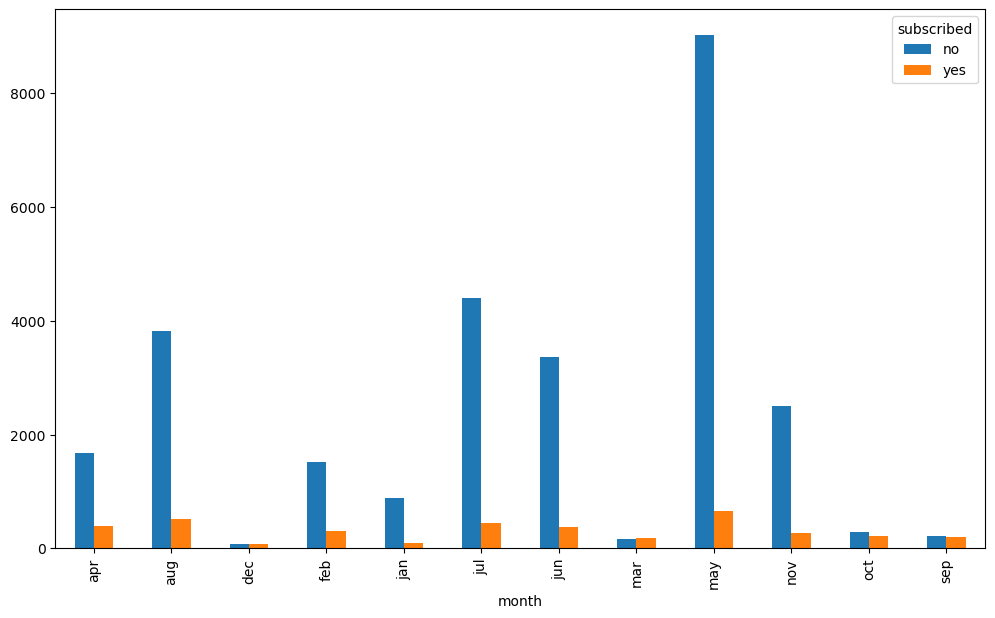

In [32]:
# "month"
temp7 = pd.crosstab(df['month'], df['subscribed'])
temp7.plot(kind='bar')
print(df.groupby(['month']).size()/len(df)*100)

poutcome
failure    10.623440
other       4.069896
success     3.374727
unknown    81.931937
dtype: float64


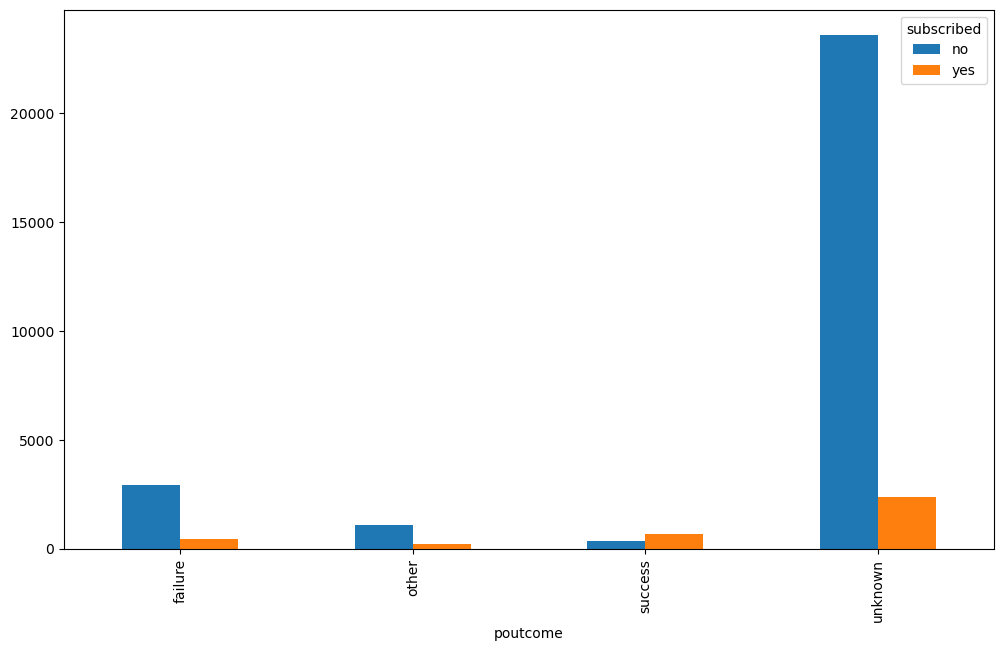

In [33]:
# "poutcome"
temp8 = pd.crosstab(df['poutcome'], df['subscribed'])
temp8.plot(kind='bar')
print(df.groupby(['poutcome']).size()/len(df)*100)

loan
no     83.786773
yes    16.213227
dtype: float64


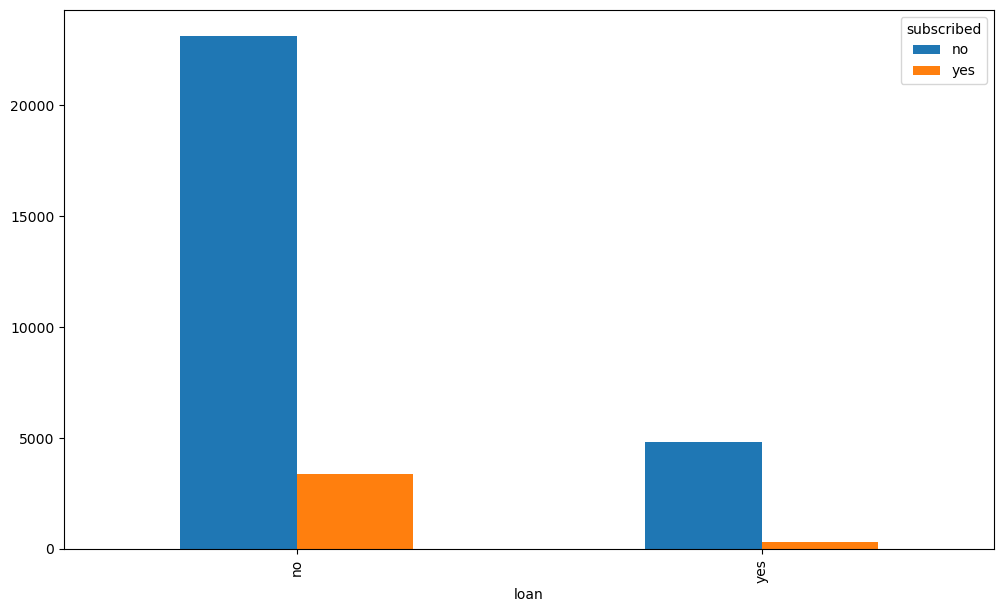

In [34]:
# "loan"
temp9 = pd.crosstab(df['loan'], df['subscribed'])
temp9.plot(kind='bar')
print(df.groupby(['loan']).size()/len(df)*100)

In [35]:
dataset_new.info()                                                    ###Updated Dataset after Exploratary Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          31647 non-null  int64  
 1   age         31647 non-null  int64  
 2   job         31647 non-null  object 
 3   marital     31647 non-null  object 
 4   education   31647 non-null  object 
 5   default     31647 non-null  object 
 6   balance     31647 non-null  float64
 7   housing     31647 non-null  object 
 8   loan        31647 non-null  object 
 9   contact     31647 non-null  object 
 10  day         31647 non-null  int64  
 11  month       31647 non-null  object 
 12  duration    31647 non-null  float64
 13  campaign    31647 non-null  float64
 14  pdays       31647 non-null  float64
 15  previous    31647 non-null  float64
 16  poutcome    31647 non-null  object 
 17  subscribed  31647 non-null  object 
dtypes: float64(5), int64(3), object(10)
memory usage: 4.3+ MB


In [36]:
#Seperating Target variable from other variables
dataset_Y = dataset_new['subscribed']
dataset_X = dataset_new[dataset_new.columns[0:12]]

In [37]:
#converting Independent Categorical into Numeriacal by creating Dummy variables
dataset_X_dummy = pd.get_dummies(dataset_X)
print(dataset_X_dummy.head())

      ID  age  balance  day  job_admin.  job_blue-collar  job_entrepreneur  \
0  26110   56   1933.0   19           1                0                 0   
1  40576   31      3.0   20           0                0                 0   
2  15320   27    891.0   18           0                0                 0   
3  43962   57   3287.0   22           0                0                 0   
4  29842   31    119.0    4           0                0                 0   

   job_housemaid  job_management  job_retired  ...  month_dec  month_feb  \
0              0               0            0  ...          0          0   
1              0               0            0  ...          0          0   
2              0               0            0  ...          0          0   
3              0               1            0  ...          0          0   
4              0               0            0  ...          0          1   

   month_jan  month_jul  month_jun  month_mar  month_may  month_nov  \
0  

In [38]:
#converting dataframe into numpy Array
X = dataset_X_dummy.values
Y = dataset_Y.values

# Split-out validation dataset
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [39]:
#Scaling the values
X_t = scale(X_train)

#initially lets create 39 components which is actual number of Variables we have
pca = PCA(n_components=34)

pca.fit(X_t)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

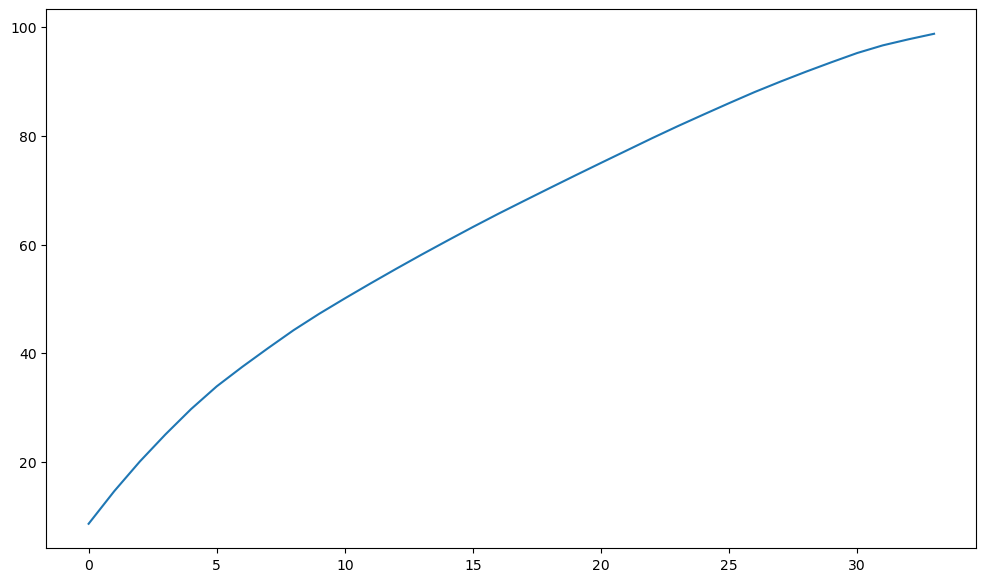

In [40]:
#lets see Cumulative Variance plot
plt.plot(var1)

### From Cumulative Variance plot we can find that first 32 components are explaining nearly 100% variability of actual data. So we will proceed with only 32 components for further modelling

In [41]:
#Looking at above plot I'm taking 32 variables
pca = PCA(n_components=32)
pca.fit(X_t)
X_train_PC=pca.fit_transform(X_t)

In [42]:
# Test options and evaluation metric                                                        ## model training
seed = 7
scoring = 'accuracy'

In [43]:
models = []
models.append(('LR', LogisticRegression()))


In [44]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train_PC, Y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.880989 (0.006686)


[Text(1, 0, 'LR')]

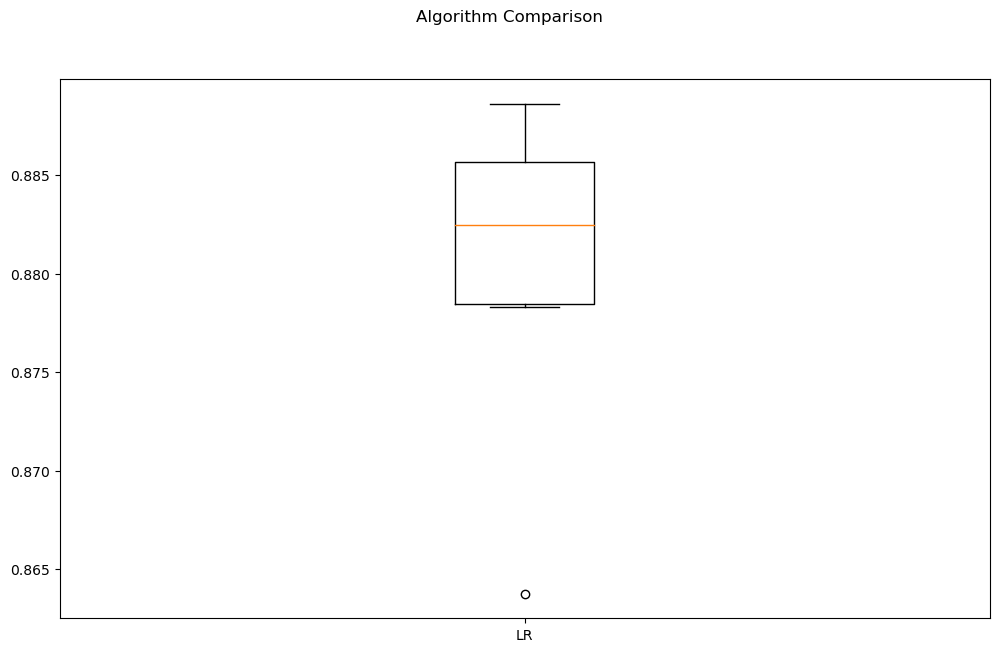

In [45]:
# Comparing Algorithms                                                                        ##model selection
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [46]:
#Scaling the X_validation data                                                         ## making prediction
X_v = scale(X_validation)

pca.fit(X_v)
X_validation_PC=pca.fit_transform(X_v)

In [47]:
# Make predictions on validation dataset by choosing best Algorithm
lr = LogisticRegression()
lr.fit(X_train_PC, Y_train)
predictions = lr.predict(X_validation_PC)
print("Accuracy : ", accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy :  0.8851500789889416
[[5581   21]
 [ 706   22]]
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      5602
         yes       0.51      0.03      0.06       728

    accuracy                           0.89      6330
   macro avg       0.70      0.51      0.50      6330
weighted avg       0.84      0.89      0.84      6330

